<a href="https://colab.research.google.com/github/MoizAhmed2517/Anime_generation_GANs/blob/main/GANs_Anime_Character_Face_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anime Face Character Generation

In [1]:
project_name = "anime_face_generation"

### Setting Configurations

In [9]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!pip install opendatasets

In [10]:
%cd /content/drive/MyDrive/ColabNotebooks/GANs_anime

/content/drive/MyDrive/ColabNotebooks/GANs_anime


In [11]:
!pwd

/content/drive/MyDrive/ColabNotebooks/GANs_anime


In [36]:
import os
import cv2
import torch
import random
import numpy as np
import torch.nn as nn
from PIL import Image
import opendatasets as od
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder

%matplotlib inline

### Downloading dataset from kaggle

In [ ]:
# dataset_url = "https://www.kaggle.com/datasets/splcher/animefacedataset"
# od.download(dataset_url)

### Making helper functions to ease our process

In [20]:
# This helper function will help us in loading images from the specified path and images will be return as a list with their relative path
def load_images(folder):
  images = []
  for path, dir, files in os.walk(folder):
    for file in files:
      images.append(os.path.join(path, file))
  return images

# This will help us to view random image, Take list as a input
def view_random_image(images):
    id = random.randint(0, len(images))
    img = cv2.imread(images[id], 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img.shape)
    plt.figure(figsize=(6, 6), dpi=40)
    plt.imshow(img)

# This will help us to denormlaize the custom normalization.
def denormalization(image_tensor, stats):
  return image_tensor * stats[1][0] + stats[0][0]

# This will help us to show the images in batch size 8*8
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denormalization(images.detach()[:nmax], STATS), nrow=8).permute(1, 2, 0))

# This function will help us to show the batches
def show_batches(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [13]:
images = load_images("./animeDataset/images")
images[0]

'./animeDataset/images/9100_2004.jpg'

(93, 93, 3)


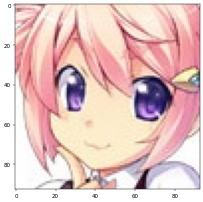

In [14]:
view_random_image(images)

### Data Preprocessing

Following are the problems with current dataset:

1. Image quality not too high. So, definetly 32 or 64 image size will be fine for cropping images.
2. We need to normalize the image dataset. We will normalize with the mean and SD of 0.5 for each channel. This will ensure the values are in the range of (-1, 1) which is more convenient for training the discriminator.
3. We will use DataLoader to load the data in batches.

**Important**: If pixel value are scaled between 0 and 1, this can push the input distribution toward the positive side which might make the activations assymetric and less effective. While, -1 and 1 aligns well for "tanh" and "LeakyRelu" in way that preventing saturations at extreme and perform better when inputs are assumetric around zero, as it helps gradients propogate more smoothly through the network.

Pixel values between -1 and 1 tend to produce a more zero-centered data distribution, which often leads to better optimization dynamics. When data is zero-centered, weight updates are more consistent and uniform across different layers of the network, improving training stability.

In [15]:
IMAGE_SIZE = 64
BATCH_SIZE = 128
STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
DATA_DIR = "./animeDataset/"

In [86]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize(*STATS)
]))

train_dl = DataLoader(train_ds,
                      BATCH_SIZE,
                      shuffle=True,
                      num_workers=3,
                      pin_memory=True
                    )

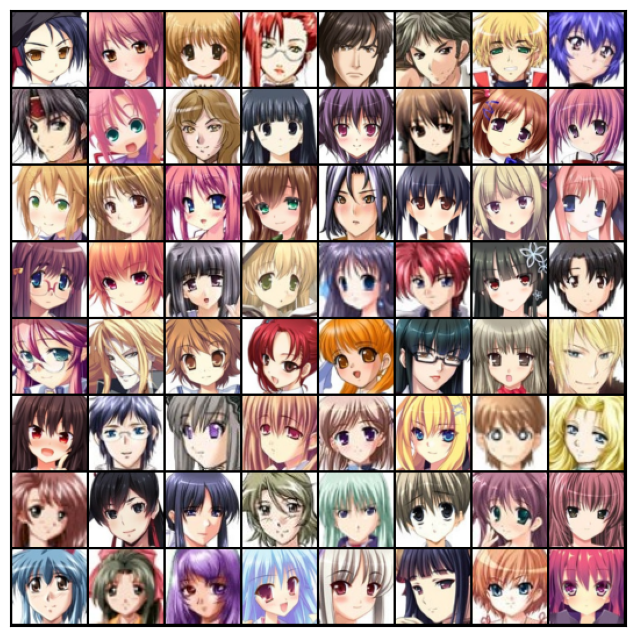

In [64]:
show_batches(train_dl)

### Using a GPU

In [87]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [88]:
device = get_default_device()

In [89]:
train_dl = DeviceDataLoader(train_dl, device)

#### Discriminator

In [90]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [91]:
discriminator = to_device(discriminator, device)

#### Generator

Generator will take latent tensor of 128x1x1 into an image tensor of shape 3x28x28. To achieve this we will use the ConvTranspose2d layer (Deconcolution)

Latent Tensor: Vector or matrix of random number which is used as a seed for generating an image.

In [92]:
LATENT_SIZE = 128

In [93]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


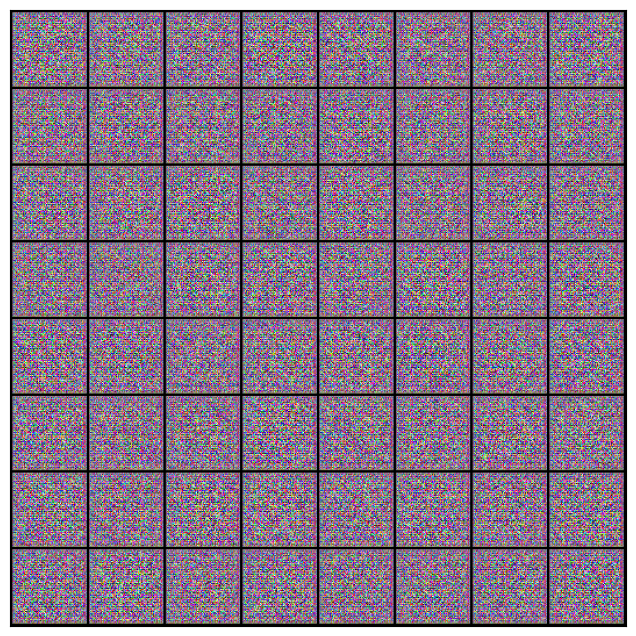

In [74]:
xb = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [94]:
generator = to_device(generator, device)

### Discriminator Training

We have design in a way that:

1. We expect that discriminator will predict 1 on real images and predict 0 when fake image from generator are created.
2. We use the loss to perform the gradient descent i.e. change the weights of the generator, so its gets etter at generating real-like images to "fool" the discriminator.

In [95]:
def train_discriminator(real_images, opt_d):

  opt_d.zero_grad()

  # pass real images through discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # Generate fake image
  latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
  fake_images = generator(latent)

  # Pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

### Generator Training

We are trying to train the generator by fooling the discriminator. We are using an elegant technique to fool discriminator. We did this thing by setting fake_image label to 1.

In [96]:
def train_generator(opt_g):
  opt_g.zero_grad()

  # Generate fake image
  latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
  fake_images = generator(latent)

  # try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(BATCH_SIZE, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  # Update generator weights
  loss.backward()
  opt_g.step()

  return loss.item()

Let's create directory where we can save our results

In [97]:
sample_dir = "./animeDataset/generated"
os.makedirs(sample_dir, exist_ok=True)

In [98]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = "generated-images-{0:0=4d}.png".format(index)
  save_image(denormalization(fake_images, STATS), os.path.join(sample_dir, fake_fname), nrow=8)
  print("Saving", fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [103]:
fixed_latent = torch.randn(64, LATENT_SIZE, 1, 1, device=get_default_device())

Saving generated-images-0000.png


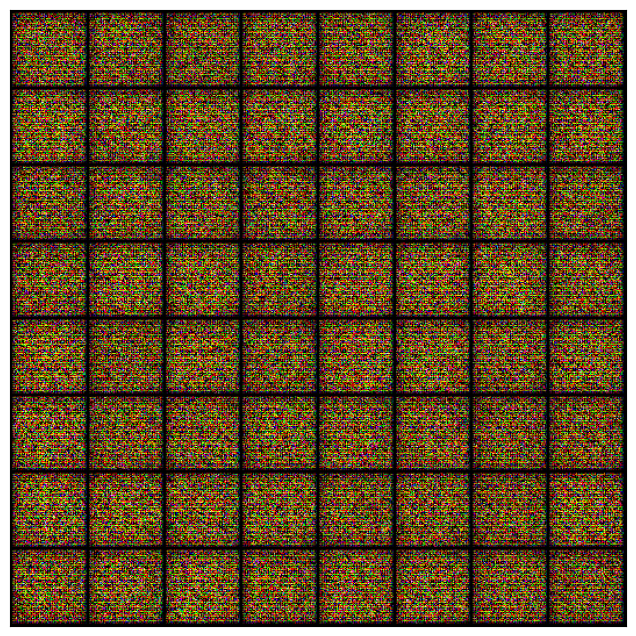

In [104]:
save_samples(0, fixed_latent)

### Making CheckPoints

In [106]:
def save_checkpoint(epoch, model_g, model_d, optimizer_g, optimizer_d, losses_g, losses_d, path="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'generator_state_dict': model_g.state_dict(),
        'discriminator_state_dict': model_d.state_dict(),
        'optimizer_g_state_dict': optimizer_g.state_dict(),
        'optimizer_d_state_dict': optimizer_d.state_dict(),
        'losses_g': losses_g,
        'losses_d': losses_d
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at epoch {epoch} at {path}")

def load_checkpoint(path="checkpoint.pth"):
    checkpoint = torch.load(path)
    epoch = checkpoint['epoch']
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    opt_g.load_state_dict(checkpoint['optimizer_g_state_dict'])
    opt_d.load_state_dict(checkpoint['optimizer_d_state_dict'])
    losses_g = checkpoint['losses_g']
    losses_d = checkpoint['losses_d']
    print(f"Checkpoint loaded from epoch {epoch} from {path}")
    return epoch, losses_g, losses_d

### Full training Loop

In [109]:
def fit(epochs, lr, start_idx=1, checkpoint_path="checkpoint.pth"):
  torch.cuda.empty_cache()

  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      loss_g = train_generator(opt_g)

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score
    ))

    save_checkpoint(epoch, generator, discriminator, opt_g, opt_d, losses_g, losses_d, checkpoint_path)

  return losses_g, losses_d, real_scores, fake_scores

In [107]:
lr = 0.0002
epochs = 25
checkpoint_path = "./animeDataset/checkpoints/gan_checkpoint.pth"
os.makedirs("./animeDataset/checkpoints", exist_ok=True)

In [ ]:
history = fit(epochs, lr, checkpoint_path=checkpoint_path)

  0%|          | 0/497 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
